In [28]:
#import data
import pandas as pd
df=pd.read_csv("SPY.USUSD_Candlestick_1_D_BID_16.02.2017-27.04.2024.csv")

In [29]:
#clean date data from csv file
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'], format='%d.%m.%Y %H:%M:%S')
df=df[df.High!=df.Low]
df.reset_index(inplace=True, drop=True)

In [30]:
import pandas_ta as ta
df['emafast'] = df.ta.ema(length=30)
df['emaslow'] = df.ta.ema(length=60)
df['rsi'] = df.ta.rsi(length=7)

In [31]:
def TotalSignal(df, emafast, emaslow, rsi):
    df['TotalSignal'] = 0
    for row in range(1, len(df)):
        if (emafast[row-1] <= emaslow[row-1]) and (emafast[row] > emaslow[row] and rsi[row] < 40):
            df.at[row, 'TotalSignal'] = 2
        elif (emafast[row-1] >= emaslow[row-1]) and (emafast[row] < emaslow[row] and rsi[row] > 60):
            df.at[row, 'TotalSignal'] = 1
    return df
        
TotalSignal(df, emafast=df.emafast, emaslow=df.emaslow, rsi=df.rsi)

,Gmt time,Open,High,Low,Close,Volume,emafast,emaslow,rsi,TotalSignal
0,2017-02-16,234.580,234.948,233.850,234.726,58.1260,NaN,NaN,NaN,0
1,2017-02-17,233.945,235.060,233.930,235.045,63.6515,NaN,NaN,NaN,0
2,2017-02-21,235.527,236.679,235.510,236.406,61.4310,NaN,NaN,NaN,0
3,2017-02-22,236.006,236.530,235.830,236.277,57.9701,NaN,NaN,NaN,0
4,2017-02-23,236.879,236.890,235.560,236.438,66.0936,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
1805,2024-04-22,497.816,502.367,495.426,499.656,1299.6000,509.521266,503.772662,33.220574,0
1806,2024-04-23,501.787,506.076,501.207,505.606,1100.7960,509.268668,503.832772,48.170374,0
1807,2024-04-24,506.516,507.356,503.116,505.456,1251.6480,509.022689,503.885992,47.855278,0
1808,2024-04-25,499.077,504.257,497.486,503.377,1590.3840,508.658451,503.869304,43.277680,0


In [32]:
import numpy as np
def pointposbreak(x):
    if x['TotalSignal']==1:
        return x['High']+1e-3
    elif x['TotalSignal']==2:
        return x['Low']-1e-3
    else:
        return np.nan

df['pointposbreak'] = df.apply(lambda row: pointposbreak(row), axis=1)

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

dfpl = df[500:700]
dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'],
                increasing=dict(line=dict(color='rgba(0, 255, 0, 0.6)', width=0.1), # Red with transparency for increasing
                fillcolor='rgba(0, 255, 0, 0.6)'),  # Match fill color with line color
                decreasing=dict(line=dict(color='rgba(255, 0, 0, 0.6)', width=0.1), # Green with transparency for decreasing
                fillcolor='rgba(255, 0, 0, 0.6)')), # Match fill color with line color),
                go.Scatter(x=dfpl.index, y=dfpl.emafast, line=dict(color='yellow', width=2), name="EMAFast"),
                go.Scatter(x=dfpl.index, y=dfpl.emaslow, line=dict(color='magenta', width=2), name="EMASlow")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=10, color="MediumPurple"),
                name="Signal")

fig.update_layout(
    width=1000,
    height=800,
    sliders=[],
    paper_bgcolor='black',  # Set the background color of the entire figure
    plot_bgcolor='black',   # Set the background color of the plotting area
    xaxis_showgrid=False,   # Remove x-axis gridlines
    yaxis_showgrid=False,   # Remove y-axis gridlines
)

fig.show()

In [34]:
dfpl = df[:].copy()

In [26]:
from backtesting import Strategy, Backtest
import pandas_ta as ta

pd.options.mode.copy_on_write = True

dfpl["EMAFast"] = ta.ema(dfpl["Close"], length=5)
dfpl["EMASlow"] = ta.ema(dfpl["Close"], length=20)
dfpl["RSI"] = ta.rsi(dfpl["Close"], length=2)

def SIGNAL():
    return dfpl.TotalSignal

class MyStrat(Strategy):
    fast_ema_len = 5
    slow_ema_len = 20
    rsi_len = 2
    mysize = 0.1

    def init(self):
        dfpl["EMAFast"] = ta.ema(dfpl["Close"], length=self.fast_ema_len)
        dfpl["EMASlow"] = ta.ema(dfpl["Close"], length=self.slow_ema_len)
        dfpl["RSI"] = ta.rsi(dfpl["Close"], length=self.rsi_len)
        self.fast_ema = self.I(lambda: dfpl["EMAFast"])
        self.slow_ema = self.I(lambda: dfpl["EMASlow"])
        self.rsi = self.I(lambda: dfpl["RSI"])

    def next(self):
        if self.fast_ema[-1] > self.slow_ema[-1] and self.fast_ema[-2] <= self.slow_ema[-2] and self.rsi[-1] < 40:
            for trade in self.trades:
                if trade.is_short:
                    trade.close()
            if len(self.trades) == 0:
                self.buy(size=self.mysize)

        elif self.fast_ema[-1] < self.slow_ema[-1] and self.fast_ema[-2] >= self.slow_ema[-2] and self.rsi[-1] > 60:
            for trade in self.trades:
                if trade.is_long:
                    trade.close()
            if len(self.trades) == 0:
                self.sell(size=self.mysize)

bt = Backtest(dfpl, MyStrat, cash=100000, margin=1/10, commission=.000)
stats, heatmap = bt.optimize(fast_ema_len=range(5, 100, 5),
                    slow_ema_len=range(40, 200, 10),
                    rsi_len=range(2, 30, 2),
                    maximize='Return [%]', max_tries=400,
                    random_state=0,
                    return_heatmap=True)
stats

C:\Users\shive\AppData\Local\Temp\ipykernel_27312\595007293.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\shive\AppData\Local\Temp\ipykernel_27312\595007293.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\shive\AppData\Local\Temp\ipykernel_27312\595007293.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Start                                     0.0
End                                     199.0
Duration                                199.0
Exposure Time [%]                        62.5
Equity Final [$]                   113844.457
Equity Peak [$]                    113844.457
Return [%]                          13.844457
Buy & Hold Return [%]               14.201289
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -5.999694
Avg. Drawdown [%]                   -0.913636
Max. Drawdown Duration                   65.0
Avg. Drawdown Duration               8.384615
# Trades                                  1.0
Win Rate [%]                            100.0
Best Trade [%]                      13.854218
Worst Trade [%]                     13.854218
Avg. Trade [%]                    

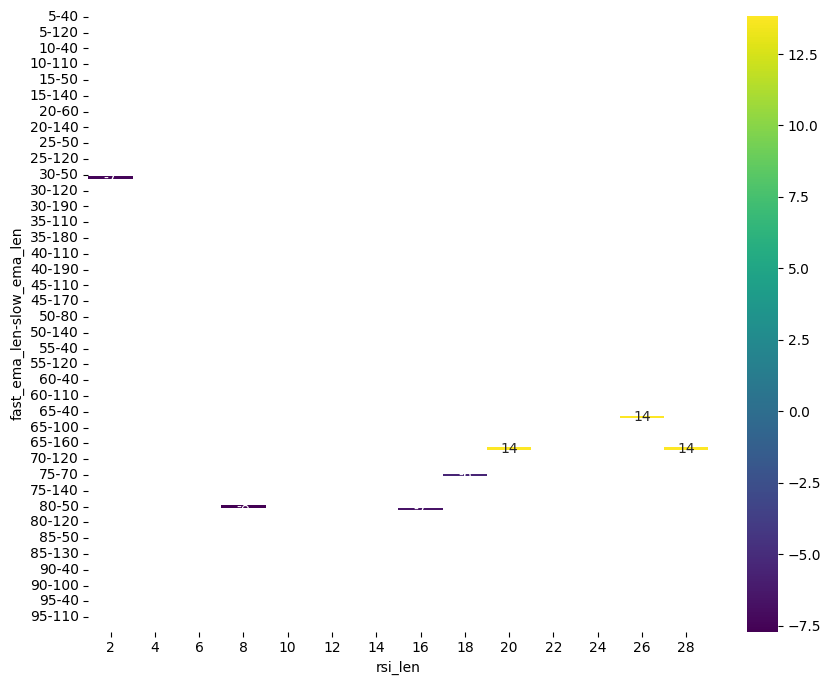

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()